In [1]:
import os
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np
from sklearn import datasets
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit

# 2

In [2]:
# Cargo el excel de la EPH
eph = pd.read_excel("usu_individual_T121.xlsx")

### a)

In [3]:
# Me quedo solo con los aglomerados de CABA y GBA
eph.drop(eph[(eph['AGLOMERADO'] != 32) & (eph["AGLOMERADO"] != 33)].index, inplace = True)
eph.reset_index(inplace = True, drop = True)

In [4]:
# Visualizo el df
eph.sample(10)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH
2883,TQRMNORRWHLNQSCDEIJAH00651115,2021,1,1,4,0,1,S,33,2334,...,0.0,12.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0
2652,TQRMNOQYVHJNOOCDEIJAH00693099,2021,1,1,2,1,1,S,33,2023,...,0.0,6.0,15225.0,4.0,0.0,4.0,4.0,0.0,4.0,3353
2269,TQRMNOQUTHLMMSCDEIJAH00650887,2021,1,1,4,1,1,S,33,2495,...,0.0,7.0,17500.0,4.0,0.0,4.0,4.0,0.0,5.0,5491
3150,TQRMNORUXHLMLOCDEIJAH00650806,2021,1,1,1,1,1,S,33,2516,...,0.0,7.0,39750.0,8.0,0.0,8.0,8.0,0.0,8.0,4071
2277,TQRMNOQUTHMMONCDEIJAH00701479,2021,1,1,5,0,1,S,33,4427,...,0.0,2.0,4200.0,1.0,0.0,1.0,1.0,0.0,1.0,7221
191,TQRMNOPWRHJLMRCDEIIAD00698182,2021,1,1,4,0,1,S,32,3041,...,0.0,9.0,51375.0,9.0,0.0,9.0,9.0,0.0,7.0,7288
968,TQRMNOWSSHKOKOCDEIIAD00655828,2021,1,1,2,1,1,S,32,3175,...,0.0,1.0,4600.0,1.0,0.0,1.0,1.0,0.0,1.0,3572
2036,TQRMNOQRVHLKRSCDEIJAH00650864,2021,1,1,1,1,1,S,33,4857,...,0.0,12.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0
1659,TQRMNOPWYHLMMMCDEIJAH00651325,2021,1,1,1,1,1,S,33,4610,...,0.0,8.0,21380.0,5.0,0.0,5.0,5.0,0.0,6.0,9987
3946,TQRMNOUSYHKMKNCDEIJAH00655860,2021,1,1,1,1,1,S,33,6994,...,0.0,6.0,60000.0,9.0,0.0,9.0,9.0,0.0,10.0,8904


### b) 

In [5]:
# Si no lo defino como uno me dropea un montón de filas que tienen NaN
eph.PP08D1 = eph.PP08D1.fillna(0)
eph.PP08F2 = eph.PP08F2.fillna(0)

In [6]:
# dropeo observaciones con valores que no tienen sentido. CH06 = edad, PP08D1, P21, P47T, ITF y IPCF son todas variables
# de ingresos, no pueden ser menores a 0
eph.drop(eph[(eph["CH06"] < 0) | (eph["PP08D1"] < 0) | (eph["P21"] < 0) | \
                       (eph["P47T"] < 0) | (eph["ITF"] < 0) | (eph["IPCF"] < 0) | (eph["PP08F2"] < 0)].index, inplace = True)
eph.reset_index(inplace = True, drop = True)

### c)

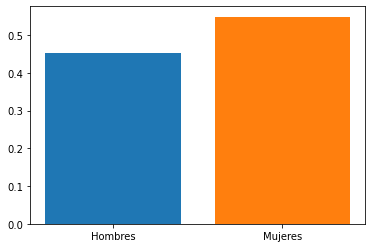

In [7]:
# Hago el eje y como un porcentaje del total. Entonces, cuento cuantos son hombres (mujeres)
# y lo divido por el total.
hombres = (eph[eph["CH04"] == 1].CH04.count())/eph.CH04.count()
mujeres = (eph[eph["CH04"] == 2].CH04.count())/eph.CH04.count()
plt.bar("Hombres", hombres)
plt.bar("Mujeres", mujeres)
plt.show()

### d)

In [8]:
# Hago el .corr() de las variables que me pedía el punto d
correlaciones = eph[["CH04", "CH07", "CH08", "NIVEL_ED", "ESTADO", "CAT_INAC", "IPCF"]].corr()

In [9]:
correlaciones.head()

,CH04,CH07,CH08,NIVEL_ED,ESTADO,CAT_INAC,IPCF
CH04,1.000000,-0.025401,-0.018404,0.034413,0.103613,0.092578,-0.043384
CH07,-0.025401,1.000000,0.093896,-0.108472,0.400843,0.376750,-0.145113
CH08,-0.018404,0.093896,1.000000,0.019925,0.016732,0.060632,-0.074722
NIVEL_ED,0.034413,-0.108472,0.019925,1.000000,-0.229064,-0.077083,0.249320
ESTADO,0.103613,0.400843,0.016732,-0.229064,1.000000,0.798244,-0.243821


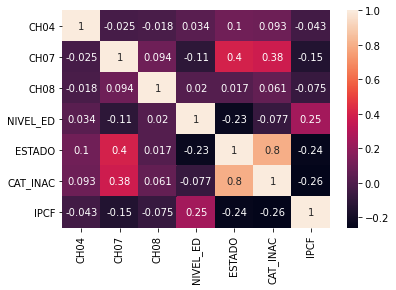

In [10]:
#Realizamos la matriz de correlaciones 
sns.heatmap(correlaciones, annot=True)
plt.show()

### e)

In [11]:
# ESTADO: 1 = Ocupado, 2 = Desocupado y 3 = Inactivo
eph[eph["ESTADO"] == 2].ESTADO.count()

204

In [12]:
eph[eph["ESTADO"] == 3].ESTADO.count()

1506

In [13]:
#para cada condición de actividad calculamos la media del ingreso per cápita familiar
eph_IPCF = eph.groupby(by=["ESTADO"]).agg({"IPCF":"mean"}) 
eph_IPCF

,IPCF
ESTADO,
0,0.000000
1,33810.842375
2,12446.200980
3,18695.858625
4,12389.373426


### f)

In [14]:
#Importamos la tabla de excel
tabla_adulto = pd.read_excel("tabla_adulto_equiv.xlsx", header = 3)

In [15]:
#Ajustamos el formato de la tabla 
tabla_adulto.dropna(axis = 1, inplace = True, thresh = 10)
tabla_adulto.dropna(inplace = True, thresh = 3)
tabla_adulto.reset_index(inplace = True, drop = True)
tabla_adulto.head(20)


,Edad,Mujeres,Varones
0,Menor de 1 año,0.35,0.35
1,1año,0.37,0.37
2,2 años,0.46,0.46
3,3 años,0.51,0.51
4,4 años,0.55,0.55
5,5 años,0.60,0.60
6,6 años,0.64,0.64
7,7 años,0.66,0.66
8,8 años,0.68,0.68
9,9 años,0.69,0.69


In [16]:
#Creamos la columna "adulto_equiv" como una columna de ceros
eph["adulto_equiv"] = 0

In [17]:
#Generamos una nueva columna llamada lista como una columna de ceros 
eph["lista"] = 0
#Iteramos por filas
#Para cada fila del data frame de acuerdo a la edad le indicamos que 
#la celda de la columna "lista" la complete con el número correspondiente 
#al índice de la tabla_adulto. 
#Por ejemplo, si la edad es menor a 30 entonces se asigna el numero 18 que es
#el índice de la fila de 18 a 29 años. 
for i in eph.index:
    if eph.loc[i, "CH06"] < 19:
        eph.loc[i, "lista"] = eph.loc[i, "CH06"]
    elif eph.loc[i, "CH06"] < 30:
        eph.loc[i, "lista"] = 18
    elif eph.loc[i, "CH06"] < 46:
        eph.loc[i, "lista"] = 19
    elif eph.loc[i, "CH06"] < 61:
        eph.loc[i, "lista"] = 20
    elif eph.loc[i, "CH06"] < 76:
        eph.loc[i, "lista"] = 21
    else:
        eph.loc[i, "lista"] = 22

In [18]:
#CH06 = edad, CH04 = Sexo (1 = varon y 2 = mujer)
#Para cada fila del dataframe si el individuo es varón entonces le indicamos que bajo 
#la columna"adulto_equiv" coloque la siguiente celda de tabla_adulto: 
# Fila: el índice que esta guardado en la columna "lista" en el df eph. 
# Columna: Varones 
#idem para las mujeres
#De este modo se obtienenn los valores de adulto equivalente de cada persona según 
#su sexo y edad
for i in eph.index:
    if eph.loc[i, "CH04"] == 1:
        eph.loc[i, "adulto_equiv"] = tabla_adulto.loc[eph.loc[i, "lista"], "Varones"]
    elif eph.loc[i, "CH04"] == 2:
        eph.loc[i, "adulto_equiv"] = tabla_adulto.loc[eph.loc[i, "lista"], "Mujeres"]

In [19]:
#Eliminamos la columna "lista"
eph.drop("lista", axis = 1, inplace = True)

In [20]:
#Visualizamos los resultados
eph[["CH04", "adulto_equiv", "CH06"]]

,CH04,adulto_equiv,CH06
0,1,1.02,29
1,2,0.76,29
2,2,0.76,53
3,2,0.76,22
4,1,1.02,19
...,...,...,...
3322,2,0.67,74
3323,2,0.67,61
3324,1,0.83,70
3325,2,0.77,15


In [21]:
#Realizamos un groupby: para cada hogar sumamos "adulto_equiv"
ad_equiv_hogar = eph[["CODUSU", "adulto_equiv"]].groupby("CODUSU").sum()
ad_equiv_hogar.reset_index(inplace = True)
ad_equiv_hogar 

,CODUSU,adulto_equiv
0,TQRMNOPPQHJMQLCDEIJAH00702455,1.67
1,TQRMNOPPQHJNMQCDEIJAH00698190,3.10
2,TQRMNOPPQHJONQCDEIJAH00693114,1.76
3,TQRMNOPPQHKMOSCDEIJAH00656008,2.53
4,TQRMNOPPQHLMPPCDEIJAH00701610,3.92
...,...,...
1318,TQUMNORVRHMMLLCDEIJAH00698180,2.27
1319,TQUMNOSTYHLKKQCDEIIAD00650359,0.83
1320,TQVMNOPYPHLOTOCDEIJAH00693364,0.67
1321,TQVMNOSTYHLKKQCDEIIAD00650333,1.23


In [22]:
#cambiamos los nombres de las columnas
ad_equiv_hogar.columns = ["CODUSU", "ad_equiv_hogar"]
ad_equiv_hogar

,CODUSU,ad_equiv_hogar
0,TQRMNOPPQHJMQLCDEIJAH00702455,1.67
1,TQRMNOPPQHJNMQCDEIJAH00698190,3.10
2,TQRMNOPPQHJONQCDEIJAH00693114,1.76
3,TQRMNOPPQHKMOSCDEIJAH00656008,2.53
4,TQRMNOPPQHLMPPCDEIJAH00701610,3.92
...,...,...
1318,TQUMNORVRHMMLLCDEIJAH00698180,2.27
1319,TQUMNOSTYHLKKQCDEIIAD00650359,0.83
1320,TQVMNOPYPHLOTOCDEIJAH00693364,0.67
1321,TQVMNOSTYHLKKQCDEIIAD00650333,1.23


In [23]:
#agregamos la columnna "ad_equiv_hogar" al df eph
eph = eph.merge(ad_equiv_hogar, on = "CODUSU", how = "outer")
eph

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH,adulto_equiv,ad_equiv_hogar
0,TQRMNOPPRHKMLNCDEIIAD00655703,2021,1,1,1,1,1,S,32,1394,...,127500.0,10.0,0.0,10.0,10.0,0.0,10.0,2494,1.02,1.78
1,TQRMNOPPRHKMLNCDEIIAD00655703,2021,1,1,2,1,1,S,32,1394,...,127500.0,10.0,0.0,10.0,10.0,0.0,10.0,2494,0.76,1.78
2,TQRMNOPPWHKMNUCDEIIAD00655837,2021,1,1,2,1,1,S,32,3090,...,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0,0.76,3.44
3,TQRMNOPPWHKMNUCDEIIAD00655837,2021,1,1,3,1,1,S,32,3090,...,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0,0.76,3.44
4,TQRMNOPPWHKMNUCDEIIAD00655837,2021,1,1,4,1,1,S,32,3090,...,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0,1.02,3.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,TQUMNOQWTHLOTOCDEIJAH00698524,2021,1,1,2,1,1,S,33,1745,...,16650.0,4.0,0.0,4.0,4.0,0.0,5.0,2388,0.67,1.67
3323,TQUMNORVRHMMLLCDEIJAH00698180,2021,1,1,1,1,1,S,33,2064,...,6400.0,1.0,0.0,1.0,1.0,0.0,1.0,3654,0.67,2.27
3324,TQUMNORVRHMMLLCDEIJAH00698180,2021,1,1,2,1,1,S,33,2064,...,6400.0,1.0,0.0,1.0,1.0,0.0,1.0,3654,0.83,2.27
3325,TQUMNORVRHMMLLCDEIJAH00698180,2021,1,1,3,1,1,S,33,2064,...,6400.0,1.0,0.0,1.0,1.0,0.0,1.0,3654,0.77,2.27


# 3

In [24]:
eph[eph["ITF"] == 0].ITF.count()

829

In [25]:
# Divido la muestra de la EPH en gente que no respondio ingresos totales familiares (ITF) y los que sí.
norespondieron = eph[eph["ITF"] == 0]
norespondieron.reset_index(inplace = True, drop = True)
respondieron = eph[eph["ITF"] != 0]
respondieron.reset_index(inplace = True, drop = True)

# 4

In [26]:
# Le agrego la columna ingreso_necesario que nos indica según el hogar, cuánto debe ganar para no ser
# considerado pobre
ingreso_adulto_min = 18914
respondieron["ingreso_necesario"] = ingreso_adulto_min * respondieron["ad_equiv_hogar"]

<ipython-input-26-d730b41ca59f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["ingreso_necesario"] = ingreso_adulto_min * respondieron["ad_equiv_hogar"]


# 5

In [27]:
# Creo una columna dummy, que dice si el individuo es pobre o no. Depende de si sus ingresos
# son mayores a ingreso_necesario
respondieron["pobre"] = (respondieron["ITF"] < respondieron["ingreso_necesario"]).astype(int)

<ipython-input-27-382230067fb2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["pobre"] = (respondieron["ITF"] < respondieron["ingreso_necesario"]).astype(int)


In [28]:
respondieron.pobre.sum()

838

# Parte 2

# 1

In [29]:
# dropeo las columnas de ingresos
respondieron.drop(["PP08D1", "PP08D4", "PP08F1", "PP08F2", "PP08J1", "PP08J2", "PP08J3", "P21", "TOT_P12", "P47T",\
                  "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V10_M", "V11_M", "V12_M", "V18_M", "V19_AM",\
                   "V21_M", "T_VI", "ITF", "IPCF", "ingreso_necesario", "ad_equiv_hogar", "adulto_equiv"], axis = 1, inplace = True)
norespondieron.drop(["PP08D1", "PP08D4", "PP08F1", "PP08F2", "PP08J1", "PP08J2", "PP08J3", "P21", "TOT_P12", "P47T",\
                  "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V10_M", "V11_M", "V12_M", "V18_M", "V19_AM",\
                    "V21_M", "T_VI", "ITF", "IPCF", "ad_equiv_hogar", "adulto_equiv"], axis = 1, inplace = True)

C:\Users\felip\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [30]:
# Nos dimos cuenta tarde que me faltan cambiar algunas para que no aparezcan NaN y dropear las de deciles
respondieron["CH14"].fillna(99, inplace = True) #Muchos no respondieron entonces reemplazamos los missing por 99. 
respondieron.drop(["CH15_COD", "CH16_COD", "PP03C", "PP03D", "CODUSU", "PP09A_ESP", "PP09C_ESP", "IDECOCUR", "PDECOCUR", \
                   "IDECINDR", "PDECINDR"], axis = 1, inplace = True) # innecesarios (con muy pocas o ninguna observación) o de ingreso
respondieron.iloc[:, 92:118] = respondieron.iloc[:, 92:118].fillna(0)
respondieron.iloc[:, 39:92] = respondieron.iloc[:, 39:92].fillna(0) # Son subcategorías que dejaban muchos NaN porque solo responndían 
#algunos entonces reemplazamos los missing por 0. 
respondieron["IMPUTA"].fillna(0, inplace = True) # Solo hay 4 imputados registrados, los demás eran NaN
respondieron.drop(["DECOCUR", "RDECOCUR", "GDECOCUR", "ADECOCUR", "PONDIIO", "DECIFR", "IDECIFR", "RDECIFR", "GDECIFR",\
                   "PONDII", "PONDIH", "PONDERA", "PDECIFR", "ADECIFR", "DECCFR", "IDECCFR", "RDECCFR", "GDECCFR",\
                  "PDECCFR", "ADECCFR", "DECINDR", "RDECINDR", "GDECINDR", "ADECINDR", "CH05"], axis = 1, inplace = True) # todas deciles
respondieron.reset_index(inplace = True, drop = True)

C:\Users\felip\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\felip\anaconda3\lib\site-packages\pandas\core\indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [31]:
#creamos una copia del dataframe para luego recuperar las columnas que no son categóricas
respondieron_temp = respondieron.copy()

In [32]:
# Herramienta para poder utilizar variables categóricas en los modelos.
label_encoder = preprocessing.LabelEncoder()

In [33]:
# Le aplico la herramienta al df
respondieron = respondieron.apply(label_encoder.fit_transform)

In [34]:
#volvemos a introducir las columnas no categóricas 
respondieron[["PP3E_TOT", "PP3F_TOT", "PP04B2", "PP04B3_MES", "PP04B3_ANO", "PP04B3_DIA", \
              "PP05B2_MES", "PP05B2_ANO", "PP05B2_DIA", "PP11B2_MES", "PP11B2_ANO", "PP11B2_DIA"]] \
= respondieron_temp[["PP3E_TOT", "PP3F_TOT", "PP04B2", "PP04B3_MES", "PP04B3_ANO", "PP04B3_DIA", \
                     "PP05B2_MES", "PP05B2_ANO", "PP05B2_DIA", "PP11B2_MES", "PP11B2_ANO", "PP11B2_DIA"]]

# 2 y 3

In [36]:
#Agregamos la columna de 1 
respondieronx = respondieron.iloc[:, :-1]
respondieronx["inter"] = 1

In [37]:
# Divido la muestra en 2 grupos, de entrenamiento y de evaluación. La variable pobre es la dependiente,
# mientras que las variables explicativas son todas las demás columnas
X_train, X_test, y_train, y_test = train_test_split(respondieronx\
                                                    , respondieron["pobre"], test_size=0.3, random_state=101)

In [41]:
X = respondieronx.copy()
y = respondieron["pobre"]

# 4

## Logit

In [37]:
# Defino en que variables se tiene que definir el modelo, uso las de entrenamiento.
# Luego evalúo el modelo con la parte de evaluación.
log_reg = LogisticRegression(max_iter = 5000, fit_intercept = False).fit(X_train, y_train)
y_pred = log_reg.predict_proba(X_test)[:,1]

In [38]:
# Ajusto resultados para logit
y_pred = np.where(y_pred > 0.5, 1, y_pred)
y_pred = np.where(y_pred <= 0.5, 0, y_pred)

In [39]:
#Matriz de confusión 
matriz_confusion = confusion_matrix(y_test, y_pred)

print('Confusion Matrix :')
print(matriz_confusion) 

#Valores de Accuracy 
print('Accuracy Score :', accuracy_score(y_test, y_pred))

Confusion Matrix :
[[439  69]
 [101 141]]
Accuracy Score : 0.7733333333333333


In [40]:
#Valores de AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

AUC: 0.72


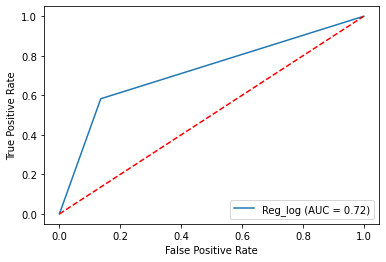

In [41]:
#Curva ROC
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Reg_log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

## Lineal

In [42]:
# Defino en que variables se tiene que definir el modelo, uso las de entrenamiento.
pob = LinearDiscriminantAnalysis()
pob = pob.fit(X_train, y_train)

In [43]:
# Luego evalúo el modelo con la parte de evaluación.
y_pred_pob = pob.predict(X_test)

In [44]:
#Valores de Accuracy
accuracy_pob = accuracy_score(y_test, y_pred_pob)
print("La precisión del modelo es: %.3f" %accuracy_pob)

La precisión del modelo es: 0.772


In [45]:
#Matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred_pob)

print('Confusion Matrix :')
print(matriz_confusion) 
print('Accuracy Score :', accuracy_score(y_test, y_pred_pob))

Confusion Matrix :
[[438  70]
 [101 141]]
Accuracy Score : 0.772


In [46]:
#Valores de AUC
auc_pob = roc_auc_score(y_test, y_pred_pob)
print('AUC: %.2f' % auc_pob)
fpr_pob, tpr_pob, thresholds_pob = roc_curve(y_test, y_pred_pob)

AUC: 0.72


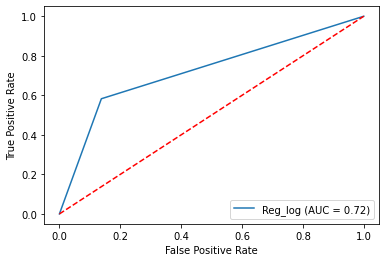

In [47]:
#Curva ROC
display = RocCurveDisplay(fpr=fpr_pob, tpr=tpr_pob, roc_auc=auc_pob, estimator_name='Reg_log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

## KNN

In [48]:
# Defino en que variables se tiene que definir el modelo, uso las de entrenamiento. y defino el n_neighbors en 3
# por como indica la consigna.
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [49]:
#Valores de Accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("La precisión del modelo es: %.2f" %accuracy_knn)

La precisión del modelo es: 0.73


In [50]:
#Matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred_knn)

print('Confusion Matrix :')
print(matriz_confusion) 
print('Accuracy Score :', accuracy_score(y_test, y_pred_knn))

Confusion Matrix :
[[406 102]
 [ 97 145]]
Accuracy Score : 0.7346666666666667


In [51]:
#Valores de AUC
auc_knn = roc_auc_score(y_test, y_pred_knn)
print('AUC: %.2f' % auc_knn)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn)

AUC: 0.70


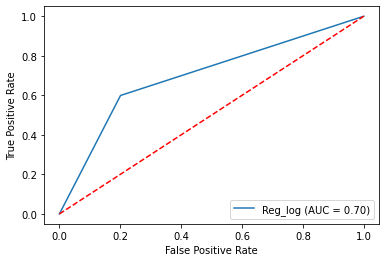

In [52]:
#Curva ROC
display = RocCurveDisplay(fpr=fpr_knn, tpr=tpr_knn, roc_auc=auc_knn, estimator_name='Reg_log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

# 6

In [53]:
# Hago lo mismo que hice al principio de la parte II con norespondieron
norespondieron["CH14"].fillna(99, inplace = True)
norespondieron.drop(["CH15_COD", "CH16_COD", "PP03C", "PP03D", "CODUSU", "PP09A_ESP", "PP09C_ESP", "IDECOCUR", "PDECOCUR", \
                   "IDECINDR", "PDECINDR"], axis = 1, inplace = True)
norespondieron.iloc[:, 92:118] = norespondieron.iloc[:, 92:118].fillna(0)
norespondieron.iloc[:, 39:92] = norespondieron.iloc[:, 39:92].fillna(0)
norespondieron["IMPUTA"].fillna(0, inplace = True)
norespondieron.drop(["DECOCUR", "RDECOCUR", "GDECOCUR", "ADECOCUR", "PONDIIO", "DECIFR", "IDECIFR", "RDECIFR", "GDECIFR",\
                   "PONDII", "PONDIH", "PONDERA", "PDECIFR", "ADECIFR", "DECCFR", "IDECCFR", "RDECCFR", "GDECCFR",\
                  "PDECCFR", "ADECCFR", "DECINDR", "RDECINDR", "GDECINDR", "ADECINDR"], axis = 1, inplace = True)
norespondieron.reset_index(inplace = True, drop = True)

C:\Users\felip\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\felip\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\felip\anaconda3\lib\site-packages\pandas\core\indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [54]:
#creamos una copia del dataframe para luego recuperar las columnas que no son categóricas
norespondieron_temp = norespondieron.copy()

In [55]:
# Le aplico el label ecoder
norespondieron = norespondieron.apply(label_encoder.fit_transform)


In [56]:
#volvemos a introducir las columnas no categóricas 
norespondieron[["PP3E_TOT", "PP3F_TOT", "PP04B2", "PP04B3_MES", \
                "PP04B3_ANO", "PP04B3_DIA", "PP05B2_MES", "PP05B2_ANO", \
                "PP05B2_DIA", "PP11B2_MES", "PP11B2_ANO", "PP11B2_DIA"]] = \
norespondieron_temp[["PP3E_TOT", "PP3F_TOT", "PP04B2", "PP04B3_MES", "PP04B3_ANO", \
                     "PP04B3_DIA", "PP05B2_MES", "PP05B2_ANO", "PP05B2_DIA", \
                     "PP11B2_MES", "PP11B2_ANO", "PP11B2_DIA"]]

In [57]:
# Le aplico el modelo a norespondieron
y_pred_nr = log_reg.predict(norespondieron)

In [58]:
# Me responde la cantidad de personas pobres que predice el modelo en norespondieron
y_pred_nr.sum()

336

In [59]:
#Obtenemos la proporcion de pobres sobre el total de los individuos que no respondieron
y_pred_nr.sum()/829

0.40530759951749096

# 7

In [60]:
#Creamos un nuevo data frame con las variables que creemos relevantes para predecir 
respondieron_filtro=respondieron[["AGLOMERADO", "MAS_500", "CH04", "CH06", "CH08",\
                                  "CH09", "CH10", "CH11", "CH12", "CH13", "CH14", "CH15",\
                                  "CH16", "NIVEL_ED", "ESTADO", "CAT_OCUP", "CAT_INAC",\
                                  "PP02E", "PP02H", "PP02I", "PP3E_TOT", "PP3F_TOT",\
                                  "PP03G", "PP03H", "PP03I", "INTENSI","PP11T", "PP11S", "PP11R",\
                                  "PP11O", "PP11N", "PP11L1", "PP11C", "PP10D", "PP10A", "PP10C", \
                                  "PP10E", "PP09C", "PP07J", "PP07K", "PP07I", "PP07H", "PP07G4", \
                                  "PP07G_59", "PP07G2", "PP07D", "PP07C", "PP07A", "PP05H", "PP04G"]]

In [61]:
# Dividimos la muestra en 2 grupos, de entrenamiento y de evaluación. La variable pobre es la dependiente,
# mientras que las variables explicativas son todas las demás columnas
X_train, X_test, y_train, y_test = train_test_split(respondieron_filtro\
                                                    , respondieron["pobre"], test_size=0.3, random_state=101)

In [74]:
# Defino en que variables se tiene que definir el modelo, uso las de entrenamiento.
# Luego evalúo el modelo con la parte de evaluación.
log_reg = LogisticRegression(max_iter = 1500, fit_intercept = True).fit(X_train, y_train)
y_pred  = log_reg.predict_proba(X_test)[:,1]

In [75]:
# Ajusto resultados para logit
y_pred = np.where(y_pred > 0.5, 1, y_pred)
y_pred = np.where(y_pred <= 0.5, 0, y_pred)

In [76]:
#Matriz de confusión 
matriz_confusion = confusion_matrix(y_test, y_pred)

print('Confusion Matrix :')
print(matriz_confusion) 

#Valores de Accuracy 
print('Accuracy Score :', accuracy_score(y_test, y_pred))

Confusion Matrix :
[[441  67]
 [101 141]]
Accuracy Score : 0.776


In [77]:
#Valores de AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

AUC: 0.73


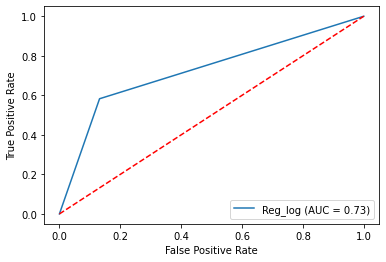

In [78]:
#Curva ROC
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Reg_log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

In [79]:
# Ajusto norespondieron a el nuevo modelo para poder predecir.
norespondieron = norespondieron[["AGLOMERADO", "MAS_500", "CH04", "CH06", "CH08",\
                                  "CH09", "CH10", "CH11", "CH12", "CH13", "CH14", "CH15",\
                                  "CH16", "NIVEL_ED", "ESTADO", "CAT_OCUP", "CAT_INAC",\
                                  "PP02E", "PP02H", "PP02I", "PP3E_TOT", "PP3F_TOT",\
                                  "PP03G", "PP03H", "PP03I", "INTENSI","PP11T", "PP11S", "PP11R",\
                                  "PP11O", "PP11N", "PP11L1", "PP11C", "PP10D", "PP10A", "PP10C", \
                                  "PP10E", "PP09C", "PP07J", "PP07K", "PP07I", "PP07H", "PP07G4", \
                                  "PP07G_59", "PP07G2", "PP07D", "PP07C", "PP07A", "PP05H", "PP04G"]]

In [80]:
# Le aplico el nuevo modelo a norespondieron
y_pred_nr = log_reg.predict(norespondieron)

In [81]:
# Me responde la cantidad de personas pobres que predice el modelo en norespondieron
y_pred_nr.sum()

236

In [82]:
#Obtenemos la proporcion de pobres sobre el total de los individuos que no respondieron
y_pred_nr.sum()/829

0.28468033775633295